# Question 9.1

In [20]:
from json import loads
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime

tweet_directory = './ECE219_tweet_data/'

statistics = []

# process each hashtag file
for file in os.listdir(tweet_directory):
    hashtag_name = file.split('.')[0].split('_')[1]

    # initializing
    total_followers = 0
    total_retweets = 0
    tweet_count = 0
    tweets_per_hour = defaultdict(int)

    earliest_time = float('inf')
    latest_time = float('-inf')

    with open(os.path.join(tweet_directory, file), encoding="utf8") as tweet_file:
        for line in tweet_file:
            tweet_data = loads(line.strip())

            followers_count = tweet_data['author']['followers']
            retweets_count = tweet_data['metrics']['citations']['total']
            tweet_time = tweet_data['citation_date']

            # convert to hourly timestamp
            timestamp = datetime.datetime.fromtimestamp(tweet_time)
            hourly_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

            total_followers += followers_count
            total_retweets += retweets_count
            tweets_per_hour[hourly_timestamp] += 1
            tweet_count += 1

            # track earliest and latest tweet timestamps
            earliest_time = min(earliest_time, tweet_time)
            latest_time = max(latest_time, tweet_time)

    # compute total hours in the dataset (including empty hours)
    total_hours = (latest_time - earliest_time) / 3600
    avg_tweets_per_hour = tweet_count / total_hours if total_hours else 0
    avg_followers_per_tweet = total_followers / tweet_count if tweet_count else 0
    avg_retweets_per_tweet = total_retweets / tweet_count if tweet_count else 0

    statistics.append({
        "Hashtag": hashtag_name,
        "Avg Tweets per Hour": avg_tweets_per_hour,
        "Avg Followers per Tweet": avg_followers_per_tweet,
        "Avg Retweets per Tweet": avg_retweets_per_tweet
    })

df_statistics = pd.DataFrame(statistics)
df_statistics.set_index("Hashtag", inplace=True)

# descending order based on Avg Tweets per Hour
df_statistics = df_statistics.sort_values(by="Avg Tweets per Hour", ascending=False)

# Display results
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.float_format', '{:.4f}'.format)  

print(df_statistics)

             Avg Tweets per Hour  Avg Followers per Tweet  Avg Retweets per Tweet
Hashtag                                                                          
#superbowl             2072.1184                8814.9680                  2.3912
#sb49                  1276.8571               10374.1603                  2.5271
#patriots               750.8943                3280.4636                  1.7853
#nfl                    397.0214                4662.3754                  1.5345
#gohawks                292.4879                2217.9237                  2.0132
#gopatriots              40.9547                1427.2526                  1.4082


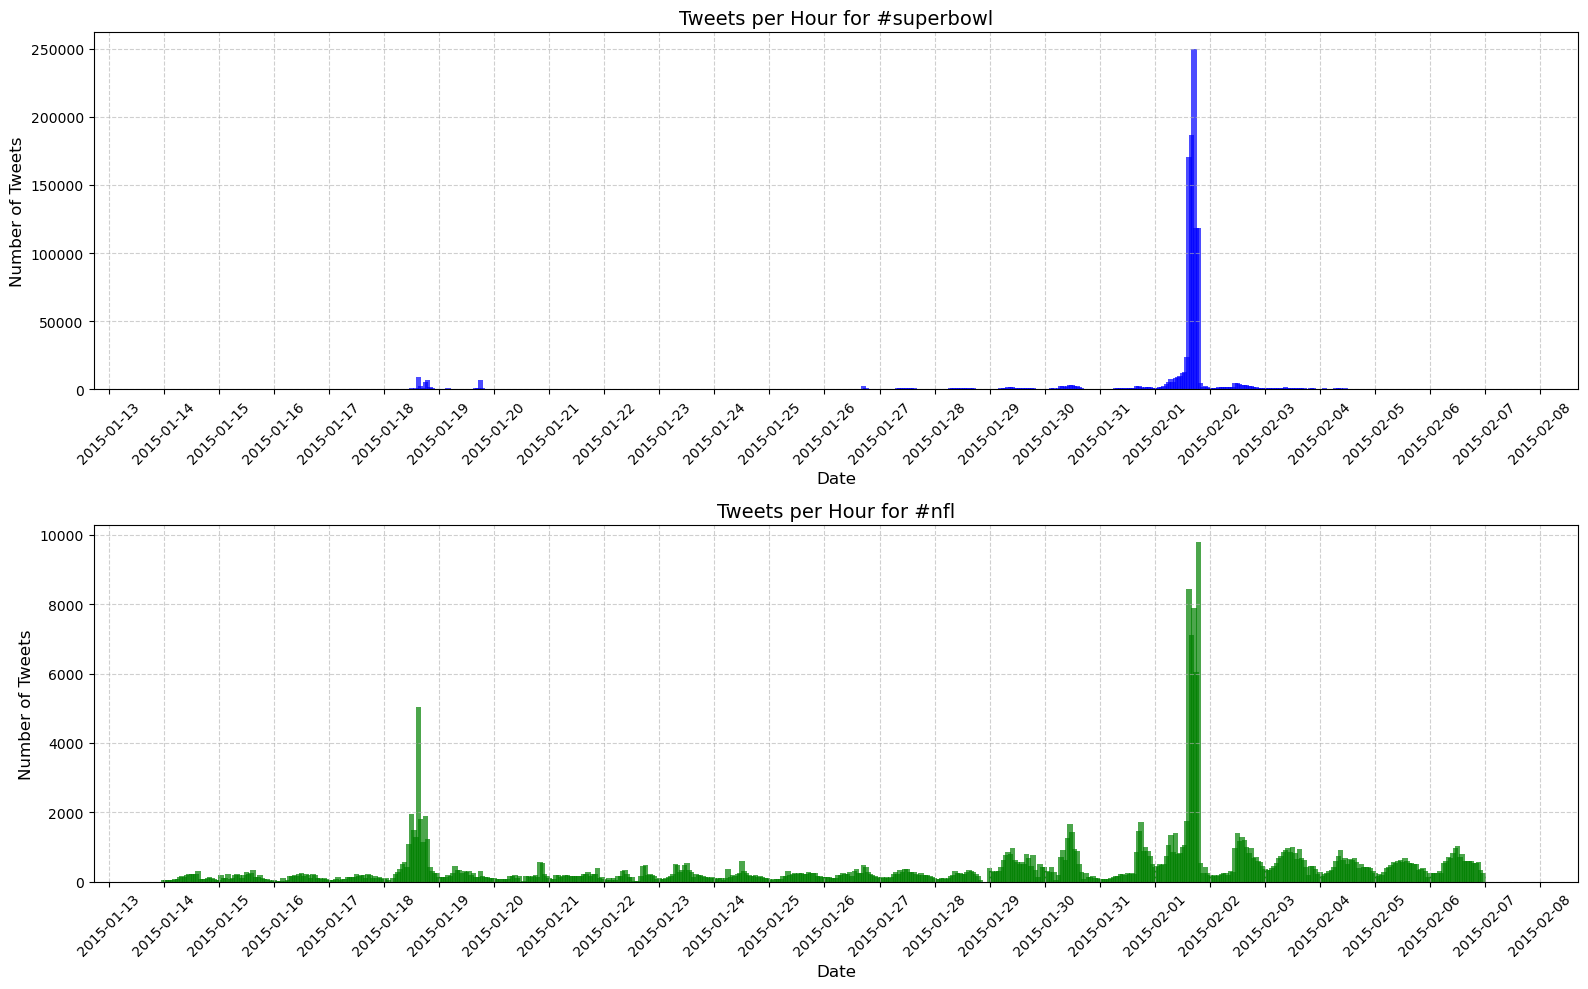

In [21]:
from json import loads
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tweet_directory = './ECE219_tweet_data/'

def process_hashtag_file(file):
    hashtag_name = file.split('.')[0].split('_')[1]
    tweets_per_hour = defaultdict(int)

    with open(os.path.join(tweet_directory, file), encoding="utf8") as tweet_file:
        for line in tweet_file:
            tweet_data = loads(line.strip())
            tweet_time = tweet_data['citation_date']

            # convert to hourly timestamp
            timestamp = datetime.datetime.fromtimestamp(tweet_time)
            hourly_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

            tweets_per_hour[hourly_timestamp] += 1

    return hashtag_name, tweets_per_hour

superbowl_file = 'tweets_#superbowl.txt'
nfl_file = 'tweets_#nfl.txt'

superbowl_hashtag, superbowl_tweets_per_hour = process_hashtag_file(superbowl_file)
nfl_hashtag, nfl_tweets_per_hour = process_hashtag_file(nfl_file)

# converting to defaultdict to a dataframe to make plotting easier
superbowl_df = pd.DataFrame(list(superbowl_tweets_per_hour.items()), columns=['Time', 'Tweets'])
nfl_df = pd.DataFrame(list(nfl_tweets_per_hour.items()), columns=['Time', 'Tweets'])

# sort the dataframes by time
superbowl_df = superbowl_df.sort_values(by='Time')
nfl_df = nfl_df.sort_values(by='Time')

# plot data
plt.figure(figsize=(16, 10)) 

# plot for #superbowl
plt.subplot(2, 1, 1)
plt.bar(superbowl_df['Time'], superbowl_df['Tweets'], color='blue', alpha=0.7, width=0.1)  # Increased bar width
plt.title(f'Tweets per Hour for {superbowl_hashtag}', fontsize=14)
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Number of Tweets', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# showing by date since labeling by hour is too hard to read
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.xticks(rotation=45)  

# plot for #nfl
plt.subplot(2, 1, 2)
plt.bar(nfl_df['Time'], nfl_df['Tweets'], color='green', alpha=0.7, width=0.1) 
plt.title(f'Tweets per Hour for {nfl_hashtag}', fontsize=14)
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Number of Tweets', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# formatting for date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

# Question 10

In [224]:
from json import loads
import pandas as pd
import datetime
import pytz  # for timezone conversion

# define the file path
file_path = './ECE219_tweet_data/tweets_#gopatriots.txt'

# initialize a list to store tweet data
tweet_data_list = []

# open the file and process each line
with open(file_path, encoding="utf8") as tweet_file:
    for line in tweet_file:
        try:
            tweet_data = loads(line.strip())

            # extract relevant fields with error handling
            followers_count = tweet_data.get('author', {}).get('followers', 0)
            retweets_count = tweet_data.get('metrics', {}).get('citations', {}).get('total', 0)
            impressions_count = tweet_data.get('metrics', {}).get('impressions', 0)  # added feature
            momentum_count = tweet_data.get('metrics', {}).get('momentum', 0)  # added feature
            
            tweet_time = tweet_data.get('citation_date', None)
            tweet_text = tweet_data.get('title', "")  
            hashtags_list = tweet_data.get("tweet", {}).get("entities", {}).get("hashtags", [])

            # extract hashtags from entities (if available)
            hashtags = [tag['text'].lower() for tag in hashtags_list]  

            # skip tweets with missing timestamp
            if tweet_time is None:
                continue

            # convert to datetime object and adjust to pacific time
            pst_timezone = pytz.timezone('America/Los_Angeles')
            timestamp = datetime.datetime.fromtimestamp(tweet_time, pst_timezone)

            # store tweet data for further analysis
            tweet_data_list.append({
                "Hashtag": "#gopatriots",
                "Text": tweet_text,
                "Timestamp": timestamp,
                "Retweets": retweets_count,
                "Followers": followers_count,
                "Impressions": impressions_count,  # added feature
                "Momentum": momentum_count,  # added feature
                "Hashtags": hashtags
            })

        except Exception as e:
            print(f"Error processing tweet: {e}")
            continue  

# convert the list of tweet data to a dataframe
df_tweets = pd.DataFrame(tweet_data_list)

# display sample tweet data
print("Sample Tweet Data:")
print(df_tweets.head())

# explore the dataset
print("\nHashtag Distribution:")
print(df_tweets['Hashtag'].value_counts())

print("\nEngagement Metrics Summary:")
print(df_tweets[['Retweets', 'Followers', 'Impressions', 'Momentum']].describe())  # removed 'Likes'

# display dataset info at the end
print("\nDataset Info:")
print(df_tweets.info())


Sample Tweet Data:
       Hashtag                                               Text                 Timestamp  Retweets  Followers  Impressions  Momentum                                           Hashtags
0  #gopatriots  LeGarrette Blount does the Ray Lewis Dance #Th... 2015-01-14 09:45:41-08:00         6  2895.0000         2695         1                    [throwbackthursday, gopatriots]
1  #gopatriots  Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M... 2015-01-14 14:44:31-08:00         4   158.0000          146         1                          [gopatriots, myfutureson]
2  #gopatriots  With both my father and husband yelling at the... 2015-01-15 09:11:15-08:00         3 20896.0000        22258         1  [gopatriots, football, patriots, newengland, yay]
3  #gopatriots  The girls soccer team is ranked the No. 3 team... 2015-01-14 17:26:29-08:00         3   500.0000          482         1                                       [gopatriots]
4  #gopatriots  @patriots Patriots Champions! 

<Axes: title={'center': 'Top 20 Hashtags'}, xlabel='Hashtag'>

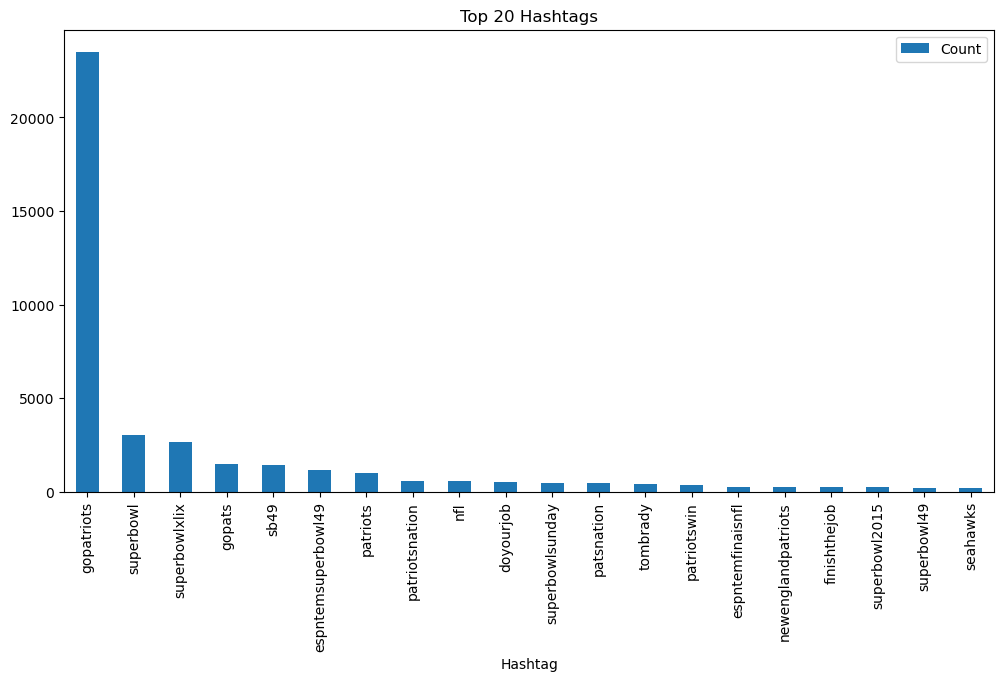

In [198]:
from collections import Counter

# flatten all hashtag lists and count occurrences
all_hashtags = [tag for tags in df_tweets["Hashtags"] for tag in tags]
hashtag_counts = Counter(all_hashtags).most_common(20)  

# convert to dataframe for plotting
df_hashtags = pd.DataFrame(hashtag_counts, columns=["Hashtag", "Count"])
df_hashtags.plot(kind="bar", x="Hashtag", y="Count", figsize=(12, 6), title="Top 20 Hashtags")


<Axes: title={'center': 'Tweet Volume by Hour'}, xlabel='Hour'>

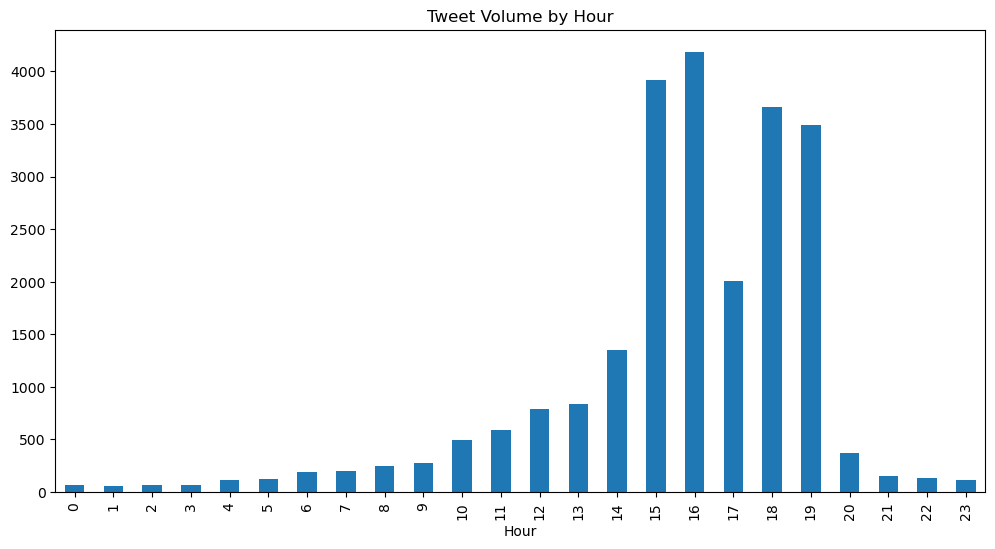

In [199]:
df_tweets["Hour"] = df_tweets["Timestamp"].dt.hour  
df_tweets.groupby("Hour").size().plot(kind="bar", figsize=(12, 6), title="Tweet Volume by Hour")


/var/folders/fk/qs9643ls43g8zjq__b4c3m4r0000gn/T/ipykernel_37058/3591365493.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Hashtag_Bins", y="Log_Retweets", data=df_tweets_filtered, ax=ax[0], palette="Blues")
/var/folders/fk/qs9643ls43g8zjq__b4c3m4r0000gn/T/ipykernel_37058/3591365493.py:30: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x="Hashtag_Bins", y="Log_Retweets", data=df_tweets_filtered, ax=ax[1], inner="quartile", bw=0.2)


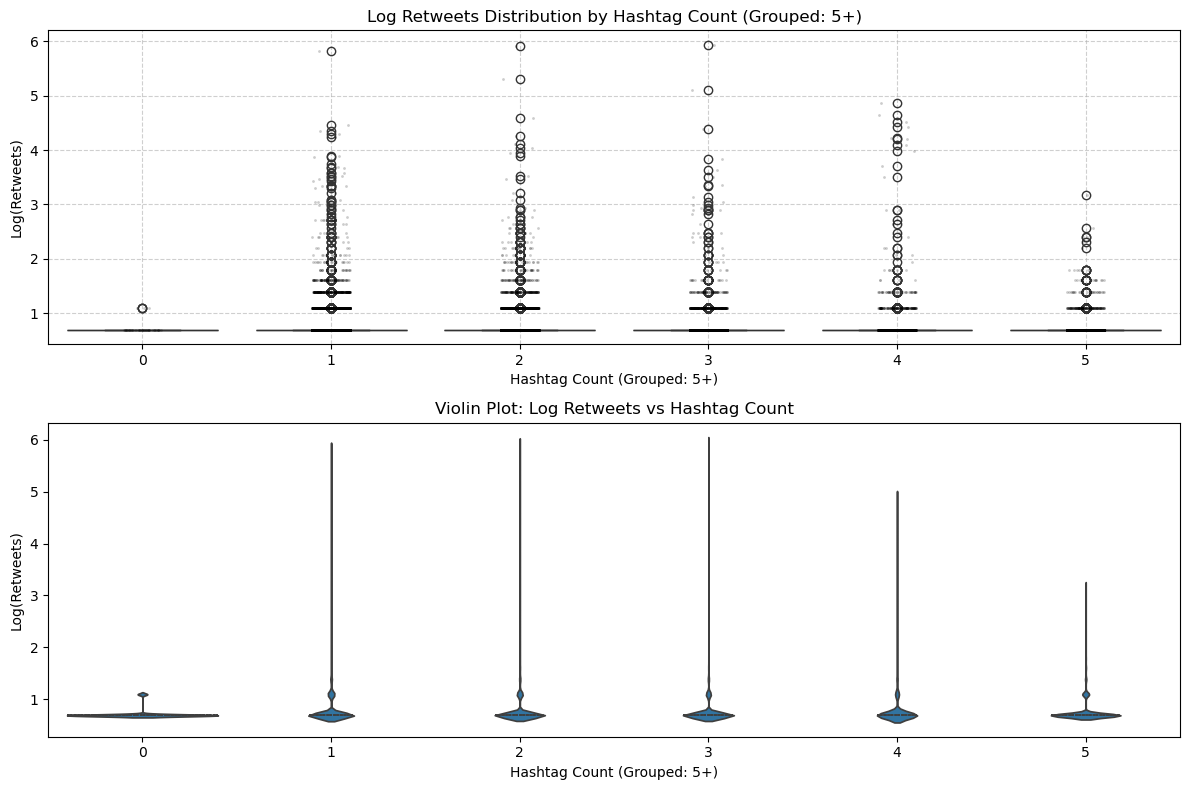

<Axes: xlabel='Hashtag_Count', ylabel='Log_Retweets'>

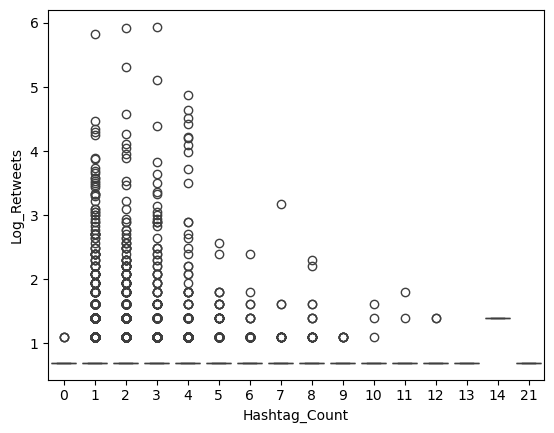

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Hashtag Count column exists
df_tweets["Hashtag_Count"] = df_tweets["Hashtags"].apply(len)

# Apply log transformation to Retweets
df_tweets["Log_Retweets"] = np.log1p(df_tweets["Retweets"])

# Group Hashtag Counts (5+ are grouped together)
df_tweets["Hashtag_Bins"] = df_tweets["Hashtag_Count"].apply(lambda x: x if x < 5 else 5)

# Sort by bins for better plotting order
df_tweets_filtered = df_tweets.sort_values(by="Hashtag_Bins")

# Create figure with two subplots (Boxplot + Violin Plot)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Boxplot with Seaborn
sns.boxplot(x="Hashtag_Bins", y="Log_Retweets", data=df_tweets_filtered, ax=ax[0], palette="Blues")
sns.stripplot(x="Hashtag_Bins", y="Log_Retweets", data=df_tweets_filtered, ax=ax[0], size=2, color="black", alpha=0.2)
ax[0].set_title("Log Retweets Distribution by Hashtag Count (Grouped: 5+)")
ax[0].set_xlabel("Hashtag Count (Grouped: 5+)")
ax[0].set_ylabel("Log(Retweets)")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Violin plot to visualize distribution
sns.violinplot(x="Hashtag_Bins", y="Log_Retweets", data=df_tweets_filtered, ax=ax[1], inner="quartile", bw=0.2)
ax[1].set_title("Violin Plot: Log Retweets vs Hashtag Count")
ax[1].set_xlabel("Hashtag Count (Grouped: 5+)")
ax[1].set_ylabel("Log(Retweets)")

# Show plot
plt.tight_layout()
plt.show()

df_tweets["Log_Retweets"] = np.log1p(df_tweets["Retweets"])
sns.boxplot(x="Hashtag_Count", y="Log_Retweets", data=df_tweets)

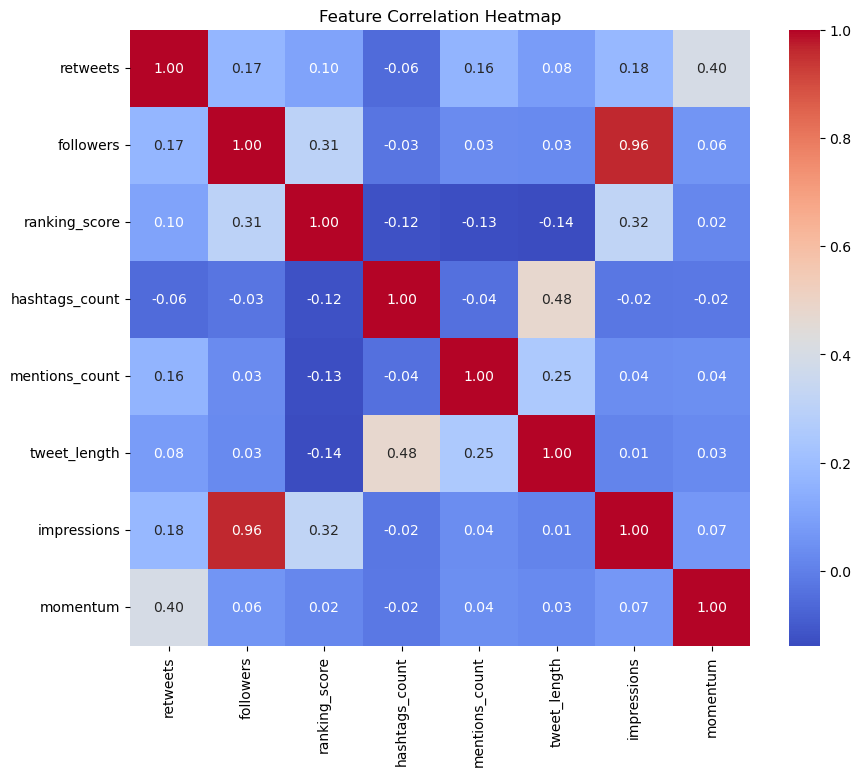

In [225]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# define the file path
file_path = "./ECE219_tweet_data/tweets_#gopatriots.txt"

# initialize data storage
data = {
    "retweets": [],
    "followers": [],
    "ranking_score": [],
    "hashtags_count": [],
    "mentions_count": [],
    "tweet_length": [],
    "impressions": [],
    "momentum": []  # added feature
}

# read and extract features
with open(file_path, "r") as f:
    for line in f:
        tweet = json.loads(line.strip())

        # extract standard features
        data["retweets"].append(tweet["metrics"]["citations"]["total"])
        data["followers"].append(tweet["author"]["followers"])
        data["ranking_score"].append(tweet["metrics"]["ranking_score"])
        data["impressions"].append(tweet["metrics"].get("impressions", 0))
        data["momentum"].append(tweet["metrics"].get("momentum", 0))  # added momentum feature

        # extract additional features
        entities = tweet.get("tweet", {}).get("entities", {})
        data["hashtags_count"].append(len(entities.get("hashtags", [])))
        data["mentions_count"].append(len(entities.get("user_mentions", [])))
        data["tweet_length"].append(len(tweet.get("title", "")))

# convert to dataframe
df = pd.DataFrame(data)

# remove zero-only hashtags & mentions
df_filtered = df[(df["hashtags_count"] > 0) | (df["mentions_count"] > 0)]

# remove extreme outliers
for col in ["followers", "ranking_score", "retweets", "impressions", "momentum"]:
    upper_limit = df_filtered[col].quantile(0.995)
    lower_limit = df_filtered[col].quantile(0.005)
    df_filtered = df_filtered[(df_filtered[col] >= lower_limit) & (df_filtered[col] <= upper_limit)]

# apply log transformation
for col in ["retweets", "followers", "ranking_score", "impressions", "momentum"]:
    df_filtered[col] = np.log1p(df_filtered[col])  

# standardize only predictor features
features = ["followers", "ranking_score", "hashtags_count", "mentions_count", "tweet_length", "impressions", "momentum"]
scaler = StandardScaler()
df_filtered[features] = scaler.fit_transform(df_filtered[features])


# plot updated correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



training with dropout...
epoch 0: train loss = 0.8906, test loss = 1.0490
epoch 20: train loss = 0.3513, test loss = 0.5222
epoch 40: train loss = 0.1203, test loss = 0.1506
epoch 60: train loss = 0.0923, test loss = 0.0426
epoch 80: train loss = 0.0788, test loss = 0.0362
epoch 100: train loss = 0.0703, test loss = 0.0310
epoch 120: train loss = 0.0657, test loss = 0.0289
epoch 140: train loss = 0.0615, test loss = 0.0291
epoch 160: train loss = 0.0600, test loss = 0.0291
epoch 180: train loss = 0.0575, test loss = 0.0284
epoch 200: train loss = 0.0554, test loss = 0.0282
epoch 220: train loss = 0.0536, test loss = 0.0276
epoch 240: train loss = 0.0526, test loss = 0.0273
epoch 260: train loss = 0.0516, test loss = 0.0274
epoch 280: train loss = 0.0508, test loss = 0.0271
epoch 300: train loss = 0.0502, test loss = 0.0271
epoch 320: train loss = 0.0504, test loss = 0.0268
epoch 340: train loss = 0.0496, test loss = 0.0269
epoch 360: train loss = 0.0485, test loss = 0.0270
epoch 380: 

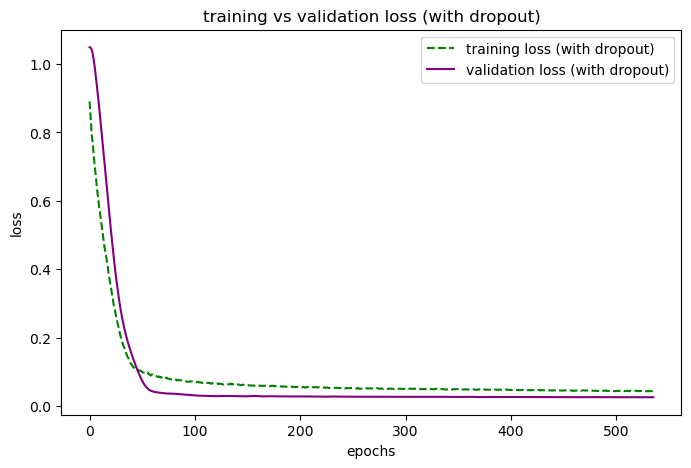


training without dropout...
epoch 0: train loss = 0.9055, test loss = 1.0125
epoch 20: train loss = 0.3450, test loss = 0.4905
epoch 40: train loss = 0.0715, test loss = 0.0803
epoch 60: train loss = 0.0321, test loss = 0.0311
epoch 80: train loss = 0.0279, test loss = 0.0271
epoch 100: train loss = 0.0268, test loss = 0.0263
epoch 120: train loss = 0.0260, test loss = 0.0255
epoch 140: train loss = 0.0250, test loss = 0.0245
epoch 160: train loss = 0.0239, test loss = 0.0233
epoch 180: train loss = 0.0227, test loss = 0.0221
epoch 200: train loss = 0.0216, test loss = 0.0209
epoch 220: train loss = 0.0209, test loss = 0.0205
epoch 240: train loss = 0.0205, test loss = 0.0201
epoch 260: train loss = 0.0202, test loss = 0.0199
epoch 280: train loss = 0.0201, test loss = 0.0198
epoch 300: train loss = 0.0200, test loss = 0.0198
epoch 320: train loss = 0.0199, test loss = 0.0198
epoch 340: train loss = 0.0198, test loss = 0.0197
epoch 360: train loss = 0.0198, test loss = 0.0196
epoch 38

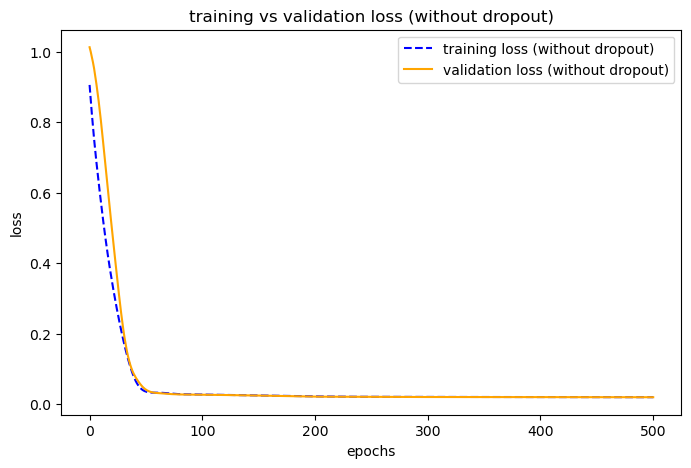

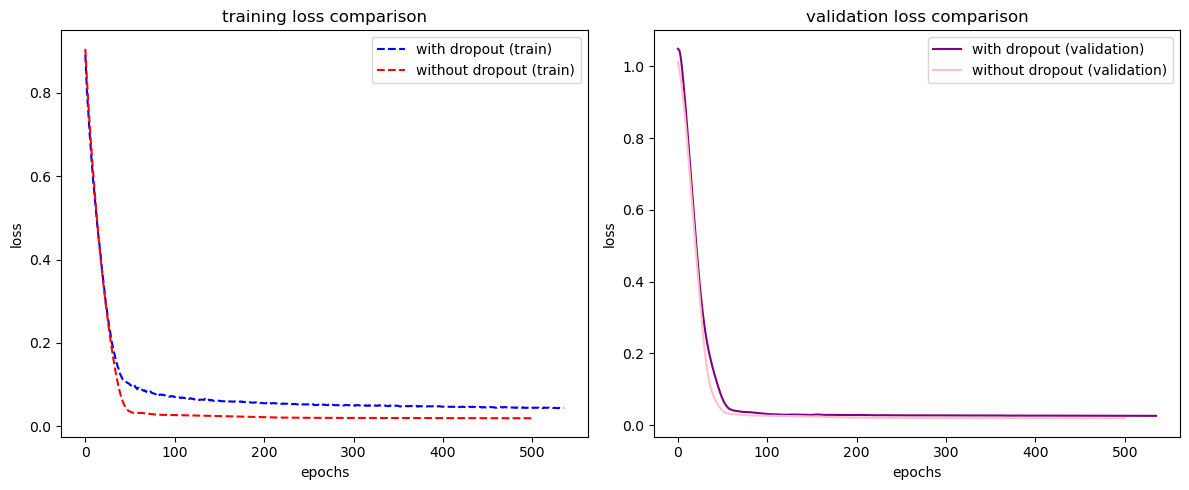

In [298]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# update feature list to ensure it matches the cleaned dataset
features = ["followers", "ranking_score", "hashtags_count", "mentions_count", "tweet_length", "impressions", "momentum"]

# prepare data for training
X = df_filtered[features]
y = df_filtered["retweets"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to pytorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# define early stopping class
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.wait = 0  

    def check_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.wait = 0  
        else:
            self.wait += 1

        return self.wait >= self.patience  

# define mlp model with batchnorm and dropout
class MLP_With_Dropout(nn.Module):
    def __init__(self, input_size):
        super(MLP_With_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)  
        self.dropout1 = nn.Dropout(0.1)  

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)  
        self.dropout2 = nn.Dropout(0.1)  

        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))  
        x = self.dropout2(x)
        x = self.fc3(x)  
        return x

# define mlp model without dropout
class MLP_Without_Dropout(nn.Module):
    def __init__(self, input_size):
        super(MLP_Without_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)

        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# training function with rmse computation and formatted epoch printout
def train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=700, patience=50, model_name=""):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)
    
    early_stopping = EarlyStopping(patience=patience)
    
    train_losses = []
    test_losses = []
    best_test_loss = float("inf")

    print(f"\ntraining {model_name}...")

    for epoch in range(epochs):
        model.train()
        y_pred_train = model(X_train_tensor)
        loss_train = criterion(y_pred_train, y_train_tensor)
        
        optimizer.zero_grad()
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)
            loss_test = criterion(y_pred_test, y_test_tensor)
        
        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())
        
        if loss_test.item() < best_test_loss:
            best_test_loss = loss_test.item()
        
        # print losses at every 20 epochs
        if epoch % 20 == 0:
            print(f"epoch {epoch}: train loss = {loss_train.item():.4f}, test loss = {loss_test.item():.4f}")

        if early_stopping.check_stop(loss_test.item()):
            print(f"early stopping at epoch {epoch}")
            break
    
    # convert test loss (mse) to rmse
    final_rmse = np.sqrt(best_test_loss)
    
    return final_rmse, train_losses, test_losses

# train with dropout
input_dim = X_train.shape[1]
model_with_dropout = MLP_With_Dropout(input_dim)
rmse_with_dropout, train_losses_with_dropout, test_losses_with_dropout = train_model(
    model_with_dropout, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, model_name="with dropout")

# plot training vs validation loss (with dropout)
plt.figure(figsize=(8, 5))
plt.plot(train_losses_with_dropout, label="training loss (with dropout)", linestyle="dashed", color="green")
plt.plot(test_losses_with_dropout, label="validation loss (with dropout)", color="purple")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training vs validation loss (with dropout)")
plt.legend()
plt.show()

# train without dropout
model_without_dropout = MLP_Without_Dropout(input_dim)
rmse_without_dropout, train_losses_without_dropout, test_losses_without_dropout = train_model(
    model_without_dropout, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, model_name="without dropout")


# plot training vs validation loss (without dropout)
plt.figure(figsize=(8, 5))
plt.plot(train_losses_without_dropout, label="training loss (without dropout)", linestyle="dashed", color="blue")
plt.plot(test_losses_without_dropout, label="validation loss (without dropout)", color="orange")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training vs validation loss (without dropout)")
plt.legend()
plt.show()

# plot both models for comparison
plt.figure(figsize=(12, 5))

# training loss comparison
plt.subplot(1, 2, 1)
plt.plot(train_losses_with_dropout, label="with dropout (train)", linestyle="dashed", color="blue")
plt.plot(train_losses_without_dropout, label="without dropout (train)", linestyle="dashed", color="red")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training loss comparison")
plt.legend()

# validation loss comparison
plt.subplot(1, 2, 2)
plt.plot(test_losses_with_dropout, label="with dropout (validation)", color="purple")
plt.plot(test_losses_without_dropout, label="without dropout (validation)", color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("validation loss comparison")
plt.legend()

plt.tight_layout()
plt.show()



In [299]:
# Compute Final RMSE
average_rmse = (rmse_with_dropout + rmse_without_dropout) / 2

# Print Final RMSE Results
print(f"\nFinal RMSE with Dropout: {rmse_with_dropout:.4f}")
print(f"Final RMSE without Dropout: {rmse_without_dropout:.4f}")
print(f"Average RMSE: {average_rmse:.4f}")


Final RMSE with Dropout: 0.1609
Final RMSE without Dropout: 0.1385
Average RMSE: 0.1497


In [304]:
# Compute train-test loss differences for both models
train_loss_final_dropout = train_losses_with_dropout[-1]  # last training loss value (with dropout)
test_loss_final_dropout = test_losses_with_dropout[-1]    # last validation loss value (with dropout)
loss_gap_dropout = abs(train_loss_final_dropout - test_loss_final_dropout)

train_loss_final_no_dropout = train_losses_without_dropout[-1]  # last training loss value (without dropout)
test_loss_final_no_dropout = test_losses_without_dropout[-1]    # last validation loss value (without dropout)
loss_gap_no_dropout = abs(train_loss_final_no_dropout - test_loss_final_no_dropout)

# Print results for model with dropout
print("\nWith Dropout:")
print(f"Final Training Loss: {train_loss_final_dropout:.4f}")
print(f"Final Test Loss: {test_loss_final_dropout:.4f}")
print(f"Train-Test Loss Gap: {loss_gap_dropout:.4f}")

if loss_gap_dropout > 0.05:
    print("Warning: Model with Dropout is Overfitting! Consider increasing dropout or reducing model complexity.")
elif loss_gap_dropout < 0.01:
    print("Model with Dropout is Well-Generalized! No overfitting detected.")
else:
    print("Model with Dropout is slightly overfitting but still reasonable.")

# Print results for model without dropout
print("\nWithout Dropout:")
print(f"Final Training Loss: {train_loss_final_no_dropout:.4f}")
print(f"Final Test Loss: {test_loss_final_no_dropout:.4f}")
print(f"Train-Test Loss Gap: {loss_gap_no_dropout:.4f}")

if loss_gap_no_dropout > 0.05:
    print("Warning: Model without Dropout is Overfitting! Consider adding dropout or reducing model complexity.")
elif loss_gap_no_dropout < 0.01:
    print("Model without Dropout is Well-Generalized! No overfitting detected.")
else:
    print("Model without Dropout is slightly overfitting but still reasonable.")

# Compare which model generalizes better
if loss_gap_dropout < loss_gap_no_dropout:
    print("\nThe model WITH dropout generalizes better (lower loss gap).")
else:
    print("\nThe model WITHOUT dropout generalizes better (lower loss gap).")



With Dropout:
Final Training Loss: 0.0442
Final Test Loss: 0.0259
Train-Test Loss Gap: 0.0183
Model with Dropout is slightly overfitting but still reasonable.

Without Dropout:
Final Training Loss: 0.0193
Final Test Loss: 0.0192
Train-Test Loss Gap: 0.0001
Model without Dropout is Well-Generalized! No overfitting detected.

The model WITHOUT dropout generalizes better (lower loss gap).


In [302]:
import numpy as np
import pandas as pd
import torch

# ensure features are in the correct order (same as training)
features = ["followers", "ranking_score", "hashtags_count", "mentions_count", "tweet_length", "impressions", "momentum"]

# example: raw input features for a new tweet
new_tweet = {
    "followers": 1200,         # example: 1200 followers
    "ranking_score": 3.5,      # example: estimated ranking score
    "hashtags_count": 3,       # example: 3 hashtags used
    "mentions_count": 2,       # example: 2 mentions
    "tweet_length": 140,       # example: 140 characters long
    "impressions": 5000,       # example: 5000 impressions
    "momentum": 0.75           # example: tweet's momentum
}

# convert to dataframe to match scaler's format
new_tweet_df = pd.DataFrame([new_tweet], columns=features)

# apply log1p transformation to match training preprocessing
log_transformed_features = ["followers", "ranking_score", "impressions", "momentum"]
new_tweet_df[log_transformed_features] = new_tweet_df[log_transformed_features].apply(np.log1p)



# apply the trained scaler (standardize input)
new_tweet_scaled = scaler.transform(new_tweet_df[features])  


# convert to tensor
new_tweet_tensor = torch.tensor(new_tweet_scaled, dtype=torch.float32)

# choose which model to use based on RMSE
if rmse_with_dropout < rmse_without_dropout:
    print("Using model with dropout for prediction")
    model = model_with_dropout
else:
    print("Using model without dropout for prediction")
    model = model_without_dropout

# set model to evaluation mode to avoid batchnorm errors
model.eval()

# predict retweets
with torch.no_grad():  
    predicted_log_retweets = model(new_tweet_tensor).item()  # this is still in log-space

print(f"raw predicted log retweets: {predicted_log_retweets:.4f}")  # debugging

# reverse log1p transformation to get final prediction
predicted_retweets = np.expm1(predicted_log_retweets)

print(f"final predicted retweets: {predicted_retweets:.2f}")


Using model without dropout for prediction
raw predicted log retweets: 1.7038
final predicted retweets: 4.49
